# Tutorial
OceanSpy builds on software packages developed by the Pangeo community, in particular [xarray](http://xarray.pydata.org/en/stable/), [dask](https://dask.org/), and [xgcm](https://xgcm.readthedocs.io/en/stable/). It is preferable to have some familiarity with these packages to get the most out of OceanSpy. 

This tutorial will take you through the main features of OceanSpy.

If you are using SciServer, make sure that you are using the Oceanography kernel. The current kernel is displayed in the top-right corner of the notebook. You can change kernel by clicking on `Kernel`>>`Change Kernel`.

To get started, import the oceanspy package:

In [1]:
import oceanspy as ospy

If you get an error that says `No module named 'oceanspy'`, it means that you are not using the Oceanography kernel. Click on `Kernel`>>`Change Kernel`, then select `Oceanography`.

## Dask Client
As explained [here](https://examples.dask.org/xarray.html#Start-Dask-Client-for-Dashboard), starting a dask client is optional, but useful for optimization purposes because it provides a [dashboard](http://distributed.dask.org/en/latest/web.html) to monitor the computation.  

On your local computer, you can access the dask dashboard just by clicking on the link displayed by the client.
The dashboard link is currently not enabled on SciServer. Follow these instructions to visualize the dashboard on SciServer:

1. Switch to JupyterLab if you haven't done so yet (click on `Switch To JupyterLab`).
2. Copy the link of the notebook and paste to a new tab, then substitute whatever is after the last slash with 'dask'.

Here is an example:  

* **Notebook**: `https://apps.sciserver.org/dockervm40/b029009b-6b4d-11e9-8a88-5254001d4703/lab?`
* **Dashboard**: `https://apps.sciserver.org/dockervm40/b029009b-6b4d-11e9-8a88-5254001d4703/dask`

The link to the dashboard will be created after you execute the code below.

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:38471 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 2.15 GB


The client configuration can be changed and optimized for the computations needed. The main arguments to change to optimize performance are `n_workers`, `threads_per_worker`, and `memory_limit`.

## OceanDataset
An `xarray.Dataset` (or `ds`) is the only object required to initialize an `oceanspy.OceanDataset` object (or `od`).
An `od` is a collection of objects used by OceanSpy, and it can be initialized using the following command:
```python
od = ospy.OceanDataset(ds)
```
See [Import datasets](Tutorial.ipynb#Import-datasets) for step-by-step instructions on how to import your own dataset.

### Opening
Several datasets are available on SciServer (see [SciServer access](sciserver.rst#sciserver-access)).
Use `open_oceandataset.from_catalog()` to open one of these datasets (see [Dastasets](datasets.rst) for a list of available datasets).
Otherwise, you can run this notebook on any computer by downloading the get_started data and using `open_oceandataset.from_zarr()`.

Set `SciServer = True` to run this notebook on SciServer, otherwise set `SciServer = False`.

In [3]:
SciServer = False # True: SciServer - False: any computer
if SciServer:
    od = ospy.open_oceandataset.from_catalog('get_started')
else:
    import os
    if not os.path.isdir('oceanspy_get_started'):
        # Download get_started
        import subprocess
        print("Downloading and uncompressing get_started data...")
        print("...it might take a couple of minutes.")
        commands = ['wget -v -O oceanspy_get_started.tar.gz -L '
                    'https://livejohnshopkins-my.sharepoint.com/'
                    ':u:/g/personal/malmans2_jh_edu/'
                    'EXjiMbANEHBZhy62oUDjzT4BtoJSW2W0tYtS2qO8_SM5mQ?'
                    'download=1',
                    'tar xvzf oceanspy_get_started.tar.gz',
                    'rm -f oceanspy_get_started.tar.gz']
        subprocess.call('&&'.join(commands), shell=True)
    od = ospy.open_oceandataset.from_zarr('oceanspy_get_started')
    
print()
print(od)

...it might take a couple of minutes.
Opening dataset from [oceanspy_get_started].

<oceanspy.OceanDataset>

Main attributes:
   .dataset: <xarray.Dataset>
   .grid: <xgcm.Grid>
   .projection: <cartopy.crs.Mercator object at 0x7f3c70de9c50>

More attributes:
   .name: get_started
   .description: Small cutout from EGshelfIIseas2km_ASR_crop.
   .parameters: <class 'dict'>
   .grid_coords: <class 'dict'>


### Set functions
All attributes are stored as global attributes (strings) in the `Dataset` object, and decoded by OceanSpy.
Because of this, do not change attributes directly, but use OceanSpy's [Set methods](api.rst#set).
For example:

In [4]:
od = od.set_name('oceandataset #1', overwrite=True)
od = od.set_description('This is my first oceandataset', overwrite=True)
print(od)

<oceanspy.OceanDataset>

Main attributes:
   .dataset: <xarray.Dataset>
   .grid: <xgcm.Grid>
   .projection: <cartopy.crs.Mercator object at 0x7f3c7044df10>

More attributes:
   .name: oceandataset #1
   .description: This is my first oceandataset
   .parameters: <class 'dict'>
   .grid_coords: <class 'dict'>


The advantage of storing all the attributes in the ``Dataset`` object is that checkpoints can be created at any time (e.g., storing the Dataset in NetCDF format), and an ``OceanDataset`` object can be easily reconstructed on any computer. Thus, OceanSpy can be used at different stages of the post-processing.

### Modify Dataset objects
Most OceanSpy functions modify or add variables to `od.dataset`.
However, `od.dataset` is just a mirror object constructed from `od._ds`.
If aliases have been set (this is necessary if your dataset uses variable names that differ from the OceanSpy reference names) `od._ds` and `od.dataset` differ from each other.  

If you want to modify the ``Dataset`` object without using OceanSpy, you can easily extract it from `od` and change it using `xarray`. Then, you can re-initialize `od` if you want to use OceanSpy again.
Here is an example:

In [5]:
# Extract ds
ds = od.dataset

# Compute mean temperature
ds['meanTemp'] = ds['Temp'].mean('time')

# Re-initialize the OceanDataset
od = ospy.OceanDataset(ds)
print(od, '\n'*3, od.dataset['meanTemp'])

<oceanspy.OceanDataset>

Main attributes:
   .dataset: <xarray.Dataset>
   .grid: <xgcm.Grid>
   .projection: <cartopy.crs.Mercator object at 0x7f3c70f01f68>

More attributes:
   .name: oceandataset #1
   .description: This is my first oceandataset
   .parameters: <class 'dict'>
   .grid_coords: <class 'dict'> 


 <xarray.DataArray 'meanTemp' (Z: 55, Y: 154, X: 207)>
dask.array<mean_agg-aggregate, shape=(55, 154, 207), dtype=float64, chunksize=(55, 154, 207), chunktype=numpy.ndarray>
Coordinates:
  * X        (X) float64 -22.02 -21.98 -21.93 -21.89 ... -13.05 -13.01 -12.96
    XC       (Y, X) float64 dask.array<chunksize=(154, 207), meta=np.ndarray>
  * Y        (Y) float64 68.99 69.01 69.03 69.04 ... 71.95 71.97 72.0 72.02
    YC       (Y, X) float64 dask.array<chunksize=(154, 207), meta=np.ndarray>
  * Z        (Z) float64 -1.0 -3.5 -7.0 -11.5 ... -681.5 -696.5 -711.5 -726.5


Note: Make sure that the global attributes of the Dataset do not get lost, so you will not have to re-set the attributes of the ``OceanDataset``.
Here is an example:

In [6]:
import xarray as xr

# Extract ds
ds = od.dataset

# Compute mean salinity
ds = xr.merge([ds, ds['S'].mean('time').rename('meanS')])

# Global attributes have been dropped
print('Global attributes:', ds.attrs, '\n'*2)

# Re-set global attributes
ds.attrs = od.dataset.attrs

# Re-initialize the OceanDataset
od = ospy.OceanDataset(ds)
print(od, '\n'*3, od.dataset['meanS'])

Global attributes: {} 


<oceanspy.OceanDataset>

Main attributes:
   .dataset: <xarray.Dataset>
   .grid: <xgcm.Grid>
   .projection: <cartopy.crs.Mercator object at 0x7f3c62df1db0>

More attributes:
   .name: oceandataset #1
   .description: This is my first oceandataset
   .parameters: <class 'dict'>
   .grid_coords: <class 'dict'> 


 <xarray.DataArray 'meanS' (Z: 55, Y: 154, X: 207)>
dask.array<mean_agg-aggregate, shape=(55, 154, 207), dtype=float64, chunksize=(55, 154, 207), chunktype=numpy.ndarray>
Coordinates:
  * X        (X) float64 -22.02 -21.98 -21.93 -21.89 ... -13.05 -13.01 -12.96
    XC       (Y, X) float64 dask.array<chunksize=(154, 207), meta=np.ndarray>
  * Y        (Y) float64 68.99 69.01 69.03 69.04 ... 71.95 71.97 72.0 72.02
    YC       (Y, X) float64 dask.array<chunksize=(154, 207), meta=np.ndarray>
  * Z        (Z) float64 -1.0 -3.5 -7.0 -11.5 ... -681.5 -696.5 -711.5 -726.5


## Subsampling
There are several functions that subsample the oceandataset in different ways. For example, it is possible to extract mooring sections, conduct ship surveys, or extract particle properties (see [Subsampling](api.rst#subsampling)).
Most OceanSpy [Computing](api.rst#computing) functions make use of the [xgcm](https://xgcm.readthedocs.io/en/latest/grids.html#axes-and-positions) functionality to have multiple axes (e.g., `X` and `Xp1`) along a single physical dimension (e.g., longitude). Because we will still want to be able to perform calculations on the reduced data set, the default behavior in OceanSpy is to retain all axes. 
The following commands extract subsets of the data and show this behavior:

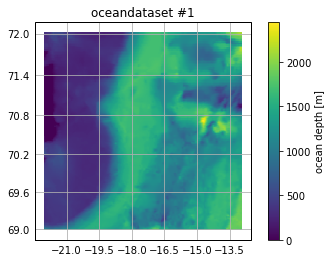

In [7]:
# Plot the original domain
%matplotlib inline
ax = od.plot.horizontal_section(varName='Depth')
title = ax.set_title(od.name)

The following commands cut out and plot a small region from the original `oceandataset`.

Cutting out the oceandataset.


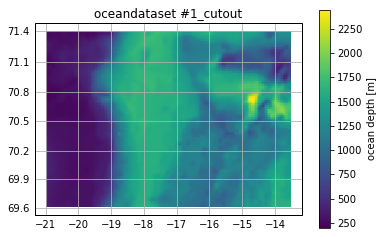

In [8]:
od_cut = od.subsample.cutout(XRange=[-21, -13.5],
                             YRange=[69.6, 71.4],
                             ZRange=0,
                             timeRange='2007-09-01')
od_cut = od_cut.set_name('cutout', overwrite=False)
# Alternatively, this syntax can be used:
# od_cut = ospy.subsample.cutout(od, ...)

# Plot the cutout domain
ax = od_cut.plot.horizontal_section(varName='Depth')
title = ax.set_title(od_cut.name)

The size of the dataset has been reduced, but all axes in the horizontal (`X`, `Xp1`, `Y`, `Yp1`), vertical (`Z`, `Zp1`, `Zu`, `Zl`), and time dimensions (`time`, `time_midp`) have been retained, so that `od_cut` is still compatible with OceanSpy:

In [9]:
print('\nOriginal: {} Gigabytes'.format(od.dataset.nbytes*1.E-9))
print(dict(od.dataset.sizes))
print('\nCutout: {} Megabytes'.format(od_cut.dataset.nbytes*1.E-6))
print(dict(od_cut.dataset.sizes))


Original: 1.034784936 Gigabytes
{'X': 207, 'Xp1': 208, 'Y': 154, 'Yp1': 155, 'Z': 55, 'Zl': 55, 'Zp1': 56, 'Zu': 55, 'time': 4, 'time_midp': 3}

Cutout: 18.010824 Megabytes
{'X': 170, 'Xp1': 171, 'Y': 93, 'Yp1': 94, 'Z': 1, 'Zl': 1, 'Zp1': 2, 'Zu': 1, 'time': 2, 'time_midp': 1}


Sometimes it could be desirable to change this default behavior, and several additional arguments are available for this purpose (see [Subsampling](api.rst#subsampling)). For example, it is possible to reduce the vertical dimension to a single location:

In [10]:
# Extract sea surface, and drop Z-axis.
od_drop = od.subsample.cutout(ZRange=0, dropAxes=True)

print('\nOriginal oceandataset:')
print(dict(od.dataset.sizes))
print(od.grid)
print('\nNew oceandataset:')
print(dict(od_drop.dataset.sizes))
print(od_drop.grid)

Cutting out the oceandataset.

Original oceandataset:
{'X': 207, 'Xp1': 208, 'Y': 154, 'Yp1': 155, 'Z': 55, 'Zl': 55, 'Zp1': 56, 'Zu': 55, 'time': 4, 'time_midp': 3}
<xgcm.Grid>
time Axis (not periodic):
  * center   time_midp --> outer
  * outer    time --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
X Axis (not periodic):
  * center   X --> outer
  * outer    Xp1 --> center
Y Axis (not periodic):
  * center   Y --> outer
  * outer    Yp1 --> center

New oceandataset:
{'X': 207, 'Xp1': 208, 'Y': 154, 'Yp1': 155, 'Z': 1, 'Zl': 1, 'Zp1': 1, 'Zu': 1, 'time': 4, 'time_midp': 3}
<xgcm.Grid>
time Axis (not periodic):
  * center   time_midp --> outer
  * outer    time --> center
X Axis (not periodic):
  * center   X --> outer
  * outer    Xp1 --> center
Y Axis (not periodic):
  * center   Y --> outer
  * outer    Yp1 --> center


Now, the vertical dimension is no longer part of the ``xgcm.Grid`` object, and all coordinates along the vertical dimensions have size 1.

## Computing
The compute module contains functions that create new variables (see [Computing](api.rst#computing)). Most OceanSpy functions use lazy evaluation, which means that the actual computation is not done until values are needed (e.g., when plotting).
There are two different types of compute functions:

* Fixed-name: Functions that do not require an input. The name of new variables is fixed.
* Smart-name: Functions that do require an input (e.g., vector calculus). The name of new variables is based on input names.

### Fixed-name
We compute the kinetic energy as an example.
This syntax returns a dataset containing the new variable:

In [11]:
ds_KE = ospy.compute.kinetic_energy(od_drop)
print(ds_KE)

Computing kinetic energy using the following parameters: {'eps_nh': 0}.
<xarray.Dataset>
Dimensions:  (X: 207, Y: 154, Z: 1, time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2007-09-01 ... 2007-09-01T18:00:00
  * Z        (Z) float64 -1.0
  * Y        (Y) float64 68.99 69.01 69.03 69.04 ... 71.95 71.97 72.0 72.02
  * X        (X) float64 -22.02 -21.98 -21.93 -21.89 ... -13.05 -13.01 -12.96
Data variables:
    KE       (time, Z, Y, X) float64 dask.array<chunksize=(4, 1, 154, 207), meta=np.ndarray>
Attributes:
    OceanSpy_description:    This is my first oceandataset
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_name:           oceandataset #1
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'jmd95', 'rho0':...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_periodic:  []


while this syntax adds the new variable to `od_drop`:

In [12]:
od_KE = od_drop.compute.kinetic_energy()
print(od_KE.dataset)

Computing kinetic energy using the following parameters: {'eps_nh': 0}.
<xarray.Dataset>
Dimensions:     (X: 207, Xp1: 208, Y: 154, Yp1: 155, Z: 1, Zl: 1, Zp1: 1, Zu: 1, time: 4, time_midp: 3)
Coordinates:
  * X           (X) float64 -22.02 -21.98 -21.93 -21.89 ... -13.05 -13.01 -12.96
  * Y           (Y) float64 68.99 69.01 69.03 69.04 ... 71.95 71.97 72.0 72.02
  * Z           (Z) float64 -1.0
  * time        (time) datetime64[ns] 2007-09-01 ... 2007-09-01T18:00:00
    XC          (Y, X) float64 dask.array<chunksize=(154, 207), meta=np.ndarray>
    XG          (Yp1, Xp1) float64 dask.array<chunksize=(155, 208), meta=np.ndarray>
    XU          (Y, Xp1) float64 dask.array<chunksize=(154, 208), meta=np.ndarray>
    XV          (Yp1, X) float64 dask.array<chunksize=(155, 207), meta=np.ndarray>
  * Xp1         (Xp1) float64 -22.04 -22.0 -21.96 ... -13.03 -12.98 -12.94
    YC          (Y, X) float64 dask.array<chunksize=(154, 207), meta=np.ndarray>
    YG          (Yp1, Xp1) float64 dask.

/srv/conda/envs/notebook/lib/python3.7/site-packages/oceanspy/_oceandataset.py:781: FutureWarning: dropping coordinates using key values of dict-like labels is deprecated; use drop_vars or a list of coordinates.
  obj = obj.drop(obj.coords)


Kinetic energy has been lazily evaluated so far.
We can trigger the computation by plotting the mean kinetic energy.

Computing weighted_mean.


/srv/conda/envs/notebook/lib/python3.7/site-packages/oceanspy/compute.py:1061: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  for dim in wMean.dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/oceanspy/_oceandataset.py:781: FutureWarning: dropping coordinates using key values of dict-like labels is deprecated; use drop_vars or a list of coordinates.
  obj = obj.drop(obj.coords)


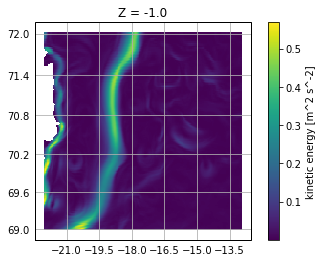

In [13]:
od_KE.plot.horizontal_section(varName='KE', meanAxes='time')

Note that OceanSpy always computes weighted means rather than regular averages!

### Smart-name
We now compute gradients as an example.
As seen above, `od.compute.gradient(...)` returns a dataset, while `od = ospy.compute.gradient(od, ...)` adds new variables to the oceandataset.
The following cell computes temperature gradients along all dimensions:

In [14]:
ds = ospy.compute.gradient(od, varNameList='Temp')
print(ds.data_vars)

Computing gradient.
Data variables:
    dTemp_dY     (time, Z, Yp1, X) float64 dask.array<chunksize=(4, 55, 1, 207), meta=np.ndarray>
    dTemp_dX     (time, Z, Y, Xp1) float64 dask.array<chunksize=(4, 55, 154, 1), meta=np.ndarray>
    dTemp_dZ     (time, Zl, Y, X) float64 dask.array<chunksize=(4, 1, 154, 207), meta=np.ndarray>
    dTemp_dtime  (time_midp, Z, Y, X) float64 dask.array<chunksize=(3, 55, 154, 207), meta=np.ndarray>


while the following code computes the temperature, salinity, and density gradients along the time dimension only. 
Note that `Sigma0` needs to be computed.

In [15]:
ds = ospy.compute.gradient(od, varNameList=['Temp', 'S', 'Sigma0'],
                           axesList=['time'])
print(ds.data_vars)

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Computing gradient.
Data variables:
    dTemp_dtime    (time_midp, Z, Y, X) float64 dask.array<chunksize=(3, 55, 154, 207), meta=np.ndarray>
    dS_dtime       (time_midp, Z, Y, X) float64 dask.array<chunksize=(3, 55, 154, 207), meta=np.ndarray>
    dSigma0_dtime  (time_midp, Z, Y, X) float64 dask.array<chunksize=(3, 55, 154, 207), meta=np.ndarray>


/srv/conda/envs/notebook/lib/python3.7/site-packages/oceanspy/_oceandataset.py:781: FutureWarning: dropping coordinates using key values of dict-like labels is deprecated; use drop_vars or a list of coordinates.
  obj = obj.drop(obj.coords)


Here is an overview of the smart-name functions:

In [16]:
print('\nGRADIENT')
print(ospy.compute.gradient(od, 'Temp').data_vars)

print('\nDIVERGENCE')
print(ospy.compute.divergence(od, iName='U', jName='V', kName='W').data_vars)

print('\nCURL')
print(ospy.compute.curl(od, iName='U', jName='V', kName='W').data_vars)

print('\nLAPLACIAN')
print(ospy.compute.laplacian(od, varNameList='Temp').data_vars)

print('\nWEIGHTED MEAN')
print(ospy.compute.weighted_mean(od, varNameList='Temp').data_vars)

print('\nINTEGRAL')
print(ospy.compute.integral(od, varNameList='Temp').data_vars)



GRADIENT
Computing gradient.
Data variables:
    dTemp_dY     (time, Z, Yp1, X) float64 dask.array<chunksize=(4, 55, 1, 207), meta=np.ndarray>
    dTemp_dX     (time, Z, Y, Xp1) float64 dask.array<chunksize=(4, 55, 154, 1), meta=np.ndarray>
    dTemp_dZ     (time, Zl, Y, X) float64 dask.array<chunksize=(4, 1, 154, 207), meta=np.ndarray>
    dTemp_dtime  (time_midp, Z, Y, X) float64 dask.array<chunksize=(3, 55, 154, 207), meta=np.ndarray>

DIVERGENCE
Computing divergence.
Computing gradient.
Data variables:
    dU_dX    (time, Z, Y, X) float64 dask.array<chunksize=(4, 55, 154, 207), meta=np.ndarray>
    dV_dY    (time, Z, Y, X) float64 dask.array<chunksize=(4, 55, 154, 207), meta=np.ndarray>
    dW_dZ    (time, Z, Y, X) float64 dask.array<chunksize=(4, 54, 154, 207), meta=np.ndarray>

CURL
Computing curl.
Computing gradient.
Computing gradient.
Computing gradient.
Computing gradient.
Data variables:
    dV_dX-dU_dY  (time, Z, Yp1, Xp1) float64 dask.array<chunksize=(4, 55, 1, 1), meta=n

/srv/conda/envs/notebook/lib/python3.7/site-packages/oceanspy/compute.py:1061: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  for dim in wMean.dims


Data variables:
    w_mean_Temp  float64 dask.array<chunksize=(), meta=np.ndarray>
    weight_Temp  (time, Z, Y, X) float64 dask.array<chunksize=(4, 55, 154, 207), meta=np.ndarray>

INTEGRAL
Computing integral.
Data variables:
    I(Temp)dtimedXdYdZ  float64 dask.array<chunksize=(), meta=np.ndarray>


All new variables have been lazily evaluated so far. The following cell triggers the evaluation of the weighted mean temperature and salinity along all dimensions: 

In [17]:
ds = ospy.compute.weighted_mean(od, varNameList=['Temp', 'S'], storeWeights=False)
for var in ds.data_vars:
    print('{} = {} {}'.format(var, ds[var].values, ds[var].attrs.pop('units', '')))

Computing weighted_mean.


/srv/conda/envs/notebook/lib/python3.7/site-packages/oceanspy/compute.py:1061: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  for dim in wMean.dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/oceanspy/compute.py:1061: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  for dim in wMean.dims


w_mean_Temp = 0.5421960292553055 degC
w_mean_S = 34.600691099468904 psu


## Plotting
Some of the plot functions have been used above. See [Plotting](api.rst#plotting) for a list of available functions.  
For example, horizontal sections are projected using the attribute `projection` of `od`.
Here we plot the mean sea surface temperature and the isobaths using different projections:

Cutting out the oceandataset.
Computing weighted_mean.


/srv/conda/envs/notebook/lib/python3.7/site-packages/oceanspy/compute.py:1061: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  for dim in wMean.dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/oceanspy/_oceandataset.py:781: FutureWarning: dropping coordinates using key values of dict-like labels is deprecated; use drop_vars or a list of coordinates.
  obj = obj.drop(obj.coords)


Computing weighted_mean.


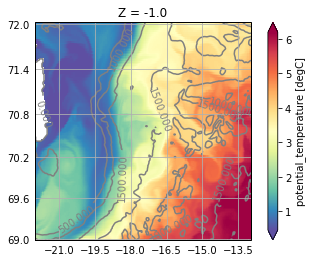

In [18]:
ax = od.plot.horizontal_section(varName='Temp',
                                contourName='Depth',
                                meanAxes='time',
                                center=False,
                                cmap='Spectral_r',
                                robust=True,
                                cutout_kwargs={'ZRange': 0,
                                               'dropAxes': True})

We can change the projection by using one the set functions of the [Set methods](api.rst#set) of the `oceandataset`.

Cutting out the oceandataset.
Computing weighted_mean.


/srv/conda/envs/notebook/lib/python3.7/site-packages/oceanspy/compute.py:1061: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  for dim in wMean.dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/oceanspy/_oceandataset.py:781: FutureWarning: dropping coordinates using key values of dict-like labels is deprecated; use drop_vars or a list of coordinates.
  obj = obj.drop(obj.coords)


Computing weighted_mean.


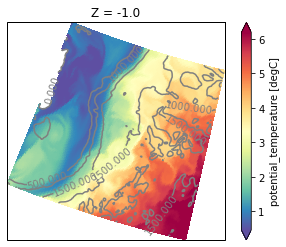

In [19]:
# Change projection
od_NPS = od.set_projection('NorthPolarStereo')
ax = od_NPS.plot.horizontal_section(varName='Temp',
                                    contourName='Depth',
                                    meanAxes=True,
                                    center=False,
                                    cmap='Spectral_r',
                                    robust=True,
                                    cutout_kwargs={'ZRange': 0,
                                                   'dropAxes': True})

## Animating
See [Animating](api.rst#animating) for a list of available functions. Plotting and animating functions have identical syntax. For example, just replace `od.plot.horizontal_section` with `od.aimate.horizontal_section` to create an animation of Sea Surface Temperature:

  0%|          | 0/4 [00:00<?, ?it/s]

Cutting out the oceandataset.


5it [00:03,  1.36it/s]                       

5it [00:04,  1.24it/s]


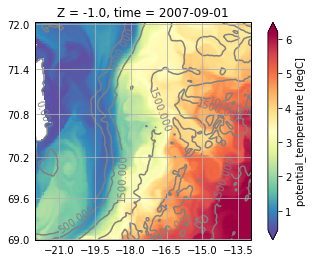

In [20]:
anim = od.animate.horizontal_section(varName='Temp',
                                     contourName='Depth',
                                     center=False,
                                     cmap='Spectral_r',
                                     robust=True,
                                     cutout_kwargs={'ZRange': 0,
                                                    'dropAxes': True},
                                     display=True)

## SciServer workflow
The SciServer Interactive mode runs on a Virtual Machine with 16 cores shared between multiple users.
Use it for notebooks that don't require heavy computations, or to test and design your notebooks.
Use the SciServer Jobs mode instead to fully exploit the computational power of SciServer.
For larger jobs, you have exclusive access to 32 logical CPU cores and 240GiB of memory. See [SciServer access](sciserver.rst#sciserver-access) for more details.

## Import datasets
The following step-by-step instructions show how to import any Ocean General Circulation Model data set:

1. Open the dataset using `xarray`. For example,

```python
import xarray as xr
ds = open_mfdataset(paths)
```

2. Create an ``OceanDataset``.

```python
import oceanspy as ospy
od = ospy.OceanDataset(ds)
```

3. Use [Set methods](api.rst#set) to connect the dataset with a `xgcm.Grid`, create aliases, set parameters, ...  
   For example, setting aliases is necessary if your dataset uses variable names that differ from the OceanSpy reference names.
   See below for a list of OceanSpy reference names and parameters. In addition, any variable computed by OceanSpy (e.g., `Sigma0`) can be aliased.
   
4. Use [Import methods](api.rst#import) if your dataset is not compatible with OceanSpy (e.g., remove NaNs from coordinate variables):

All commands above can be triggered using `ospy.open_dataset.from_catalog` and a configuration file (e.g., see [SciServer catalogs](https://github.com/malmans2/oceanspy/tree/master/sciserver_catalogs)).

Here we print the OceanSpy parameters that can be set.

In [21]:
# Print parameters
print("\n{:>15}: {}\n".format('PARAMETER NAME', 'DESCRIPTION'))
for par, desc in sorted(ospy.PARAMETERS_DESCRIPTION.items()):
    print("{:>15}: {}".format(par, desc))


 PARAMETER NAME: DESCRIPTION

            c_p: Specific heat capacity ( J/kg/K )
    dTempFrz_dS: Freezing temp. of sea water (intercept)
         eps_nh: Non-Hydrostatic coefficient.Set 0 for hydrostatic, 1 for non-hydrostatic.
       eq_state: Equation of state.
              g: Gravitational acceleration [m/s^2]
          omega: Angular velocity ( rad/s )
        rSphere: Radius of sphere for spherical polaror curvilinear grid (km).Set it None for cartesian grid.
           rho0: Reference density (Boussinesq)  ( kg/m^3 )
       tempFrz0: Freezing temp. of sea water (intercept)


While here we print the reference names of the variables used by OceanSpy.

In [22]:
# Print reference names
if SciServer:
    od = ospy.open_oceandataset.from_catalog('get_started')
else:
    import os
    if not os.path.isdir('oceanspy_get_started'):
        # Download get_started
        import subprocess
        print("Downloading and uncompressing get_started data...")
        print("...it might take a couple of minutes.")
        commands = ['wget -v -O oceanspy_get_started.tar.gz -L '
                    'https://jh.box.com/shared/static/'
                    'pw83oja1gp6mbf8j34ff0qrxp08kf64q.gz',
                    'tar xvzf oceanspy_get_started.tar.gz',
                    'rm -f oceanspy_get_started.tar.gz']
        subprocess.call('&&'.join(commands), shell=True)
    od = ospy.open_oceandataset.from_zarr('oceanspy_get_started')

table = {var: od.dataset[var].attrs.pop('description',
                                        od.dataset[var].attrs.pop('long_name', None))
         for var in od.dataset.variables}
print("\n{:>15}: {}\n".format('REFERENCE NAME', 'DESCRIPTION'))
for name, desc in sorted(table.items()):
    print("{:>15}: {}".format(name, desc))

Opening dataset from [oceanspy_get_started].

 REFERENCE NAME: DESCRIPTION

       ADVr_SLT: Vertical   Advective Flux of Salinity
        ADVr_TH: Vertical   Advective Flux of Pot.Temperature
       ADVx_SLT: Zonal      Advective Flux of Salinity
        ADVx_TH: Zonal      Advective Flux of Pot.Temperature
       ADVy_SLT: Meridional Advective Flux of Salinity
        ADVy_TH: Meridional Advective Flux of Pot.Temperature
       DFrI_SLT: Vertical Diffusive Flux of Salinity    (Implicit part)
        DFrI_TH: Vertical Diffusive Flux of Pot.Temperature (Implicit part)
          Depth: fluid thickness in r coordinates (at rest)
         EXFaqh: surface (2-m) specific humidity
       EXFatemp: surface (2-m) air temperature
       EXFempmr: net upward freshwater flux, > 0 increases salinity
        EXFevap: evaporation, > 0 increases salinity
          EXFhl: Latent heat flux into ocean, >0 increases theta
          EXFhs: Sensible heat flux into ocean, >0 increases theta
       EXFlwnet: